## Name : Adwaiy Singh
## Reg. No. : 220968424
## Sec. : A
## Batch: 2

# WEEK 8

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
!curl -O http://www.manythings.org/anki/hin-eng.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  136k  100  136k    0     0  1022k      0 --:--:-- --:--:-- --:--:-- 1024k


In [3]:
!unzip hin-eng.zip


Archive:  hin-eng.zip
  inflating: hin.txt                 
  inflating: _about.txt              


## PreProcessing

In [5]:
data_path = "hin.txt"

with open(data_path, "r", encoding="utf-8") as file:
    num_samples = sum(1 for line in file)

print("Number of samples:", num_samples)

Number of samples: 3061


In [6]:
input_texts = []
target_texts = []

input_characters = set()
target_characters = set()

with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")

for line in lines[: min(num_samples, len(lines) - 1)]:

    input_text, target_text, _ = line.split("\t")

    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)

    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [7]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 3061
Number of unique input tokens: 70
Number of unique output tokens: 92
Max sequence length for inputs: 107
Max sequence length for outputs: 123


## Preparing the Data

In [8]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):

    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0

    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

## Model Building and Training

In [9]:
latent_dim = 256

encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [11]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)

history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=64,
    epochs=1000,
    validation_split=0.2,
)

Epoch 1/1000
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.8106 - loss: 0.8349 - val_accuracy: 0.6869 - val_loss: 1.3683
Epoch 2/1000
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8078 - loss: 0.7887 - val_accuracy: 0.6588 - val_loss: 1.3399
Epoch 3/1000
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8096 - loss: 0.8125 - val_accuracy: 0.6869 - val_loss: 1.2843
Epoch 4/1000
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8086 - loss: 0.7666 - val_accuracy: 0.6913 - val_loss: 1.2872
Epoch 5/1000
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8136 - loss: 0.7663 - val_accuracy: 0.6906 - val_loss: 1.2673
Epoch 6/1000
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8170 - loss: 0.7265 - val_accuracy: 0.7011 - val_loss: 1.1834
Epoch 7/1000
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8251 - loss: 0.6997 - val_accuracy: 0.7099 - val_loss: 1.1483
Epoch 8/1000
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8334 - loss: 0.6690 - val_accu

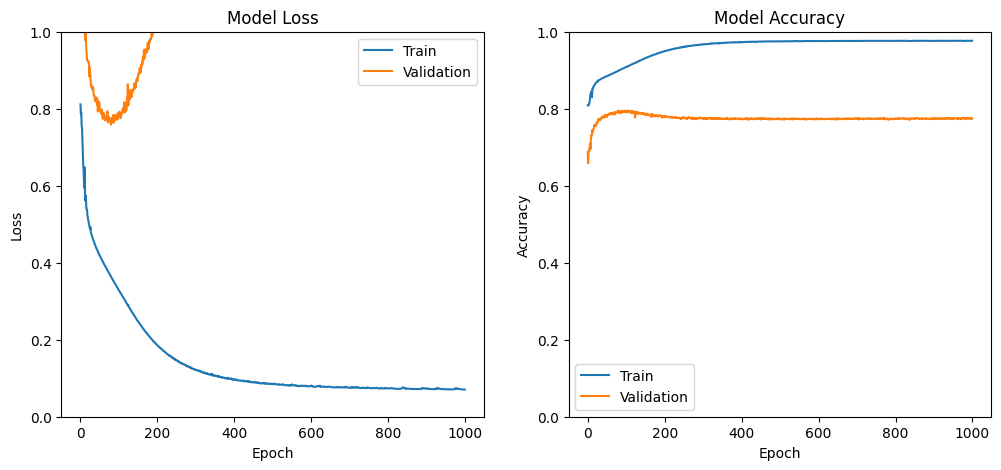

In [12]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    metrics = ['loss', 'accuracy']
    titles = ['Model Loss', 'Model Accuracy']

    plt.figure(figsize=(12, 5))
    for i, metric in enumerate(metrics):
        plt.subplot(1, 2, i+1)
        plt.plot(history.history[metric], label='Train')
        plt.plot(history.history[f'val_{metric}'], label='Validation')
        plt.title(titles[i])
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.ylim(0, 1)
        plt.legend()
    plt.show()

plot_training_history(history)

In [13]:
model.save("seq2seq.keras")

In [14]:
model = keras.models.load_model("seq2seq.keras")

encoder_inputs = model.input[0]
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [15]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        states_value = [h, c]
    return decoded_sentence

In [16]:
for seq_index in range(10):
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━